### 도시가스 고객센터 상담이력정보 분석 - 1. 인입콜 감축 방안 탐색 
- Source Data : 이지원 상담이력정보 테이별(APDB_CL_CS_COUNSEL_CALL_HISTORY_TM) 
- DB info. : DataPlatform RDS(MSSQL)
- Raw Data size : 13,558,241건 (2019.12.02~2023.07.21, 약 8.3GB) 
- 분석대상 Data size : 3,345,622건 (2022.01.01~2022.12.31, 압축후 약 446MB)
- columns 정보 : http://localhost:8888/doc/tree/work_2023/07.%EA%B5%90%EC%9C%A1_%EC%9D%B8%EC%9E%85%EC%BD%9C%ED%9A%A8%EC%9C%A8%ED%99%94/columns_detail.png
---

In [1]:
## 필수 pkg's 및 한글폰트 사용 설정 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')
import time 

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rc('axes',unicode_minus=False)

In [2]:
## Dataset loading 
df_2022 = pd.read_parquet('data/df_2022.parquet')
print(df_2022.shape)

(3345622, 64)


In [3]:
pd.set_option('display.max_columns', None)
df_2022.head(2)

,COUNSEL_CALL_HISTORY_EID,TEL,BOUND_TYPE_CODE,ARS_CHANNEL,START_TIME,END_TIME,CALL_TIME,PAYER_NUMBER,CUSTOMER_NAME,CUSTOMER_DIVISION_CLAS_CODE,DUTY_TYPE_CLAS_CODE,CENTER_NAME,CENTER_CODE,COUNSEL_NAME,CALL_RESULT_CODE,HOUSE_TYPE_CODE,USE_TYPE_CODE,CALL_ID,COUNSEL_MEMO,COUNSEL_TYPE_CODE,RELATIONSHIP_CODE,RELATIONSHIP_CENTER_CODE,ENTITY_STATUS,MOD_DATE,REG_DATE,MOD_USER_ENTITY_ID,REG_USER_ENTITY_ID,TRF_USER_ENTITY_ID,TRF_DATE,CALLBACK_TYPE_CODE,CALLBACK_FIT_CODE,DUTY_TYPE_CODE,CUSTOMER_DIVISION_CODE,BOUND_TYPE,CUSTOMER_DIVISION_CLAS,DUTY_TYPE_CLAS,HOUSE_TYPE,USE_TYPE,COUNSEL_TYPE,DUTY_TYPE,CUSTOMER_DIVISION,CALLBACK_TYPE,CALLBACK_FIT,CALL_RESULT,EXTENSION,END_CALL_TYPE,END_CALL_TYPE_CODE,REGION,REGION_CODE,GENDER,GENDER_CODE,BIRTH_DATE,PROCESS_CALLBACK_TYPE_CODE,PROCESS_CALLBACK_TYPE,URGENT_CODE,URGENT,VOC_ENTITY_ID,PARTNER,call_year,call_month,call_day,call_hour,call_weekday,call_duration
0,182612264.0,0326796155,IB,0상담원연결,2022-01-06 10:16:59,2022-01-06 10:17:55,56000.0,106824448,이영희,GENERAL,1,오정,16,None,SUCCESS,40,LOF1,548A5FA2-44DA-43C7-976B-F36D10B7CF8B,요금 내역서 발송,MODESTY,OWN,16,UPDATE,2022-01-06 10:18:11,2022-01-06 10:16:59,1721.0,1721.0,None,None,None,None,CHARGE,GENTLE,인바운드,일반,문의,공동주택,업무용,겸손,요금문의,온화함,None,None,통화성공,6091,None,None,삼정동,None,여성,F,600315.0,None,None,None,None,96953091,700737322,2022,1,6,10,Thursday,56.0
1,182612760.0,03180199756,IB,0상담원연결,2022-01-06 10:17:29,2022-01-06 10:17:59,30000.0,304366212,김진영,GENERAL,1,동인천,11,None,SUCCESS,10,LRH1,9389BB5F-A391-4B53-9254-103F496A3B89,수납센터: 번호변경&요금문자요청,DOUCENESS,OWN,11,UPDATE,2022-01-06 10:18:41,2022-01-06 10:17:30,1677.0,1677.0,None,None,None,None,CHARGE,GENTLE,인바운드,일반,문의,원룸,난방용,차분,요금문의,온화함,None,None,통화성공,6030,None,None,도화1동,None,남성,M,851024.0,None,None,None,None,96953118,707153261,2022,1,6,10,Thursday,30.0


#### 1. 부동산, 관리사무소 등으로 부터의 (이사, 전출입 관련) 인입콜 
- 현업 담당자와 협의하여 부동산/중개사/관리실 등 31개 키워드 선정 
- 상담메모('COUNSEL_MEMO')에 키워드가 포함된 건들 추출 
- 고객명('CUSTOMER_NAME')에 키워드가 포함된 건들 추출
- 관계유형('RELATIONSHIP_CODE')이 MANAGER로 기입된 건들 추출

In [4]:
## 31개 키워드 선정 
key_words = '집주인|주인|소유주|주인세대|건물주|소유자|관리인|관리실|사무실|관리사무소|관리사무실|관리소|관리자|관리|주택|건설|고시원|기숙사|부동산|중개인|중개사|중개사무소|중개사무실|공인중개사|분양사무실|분양사무소|분양|LH공사|입주자'

In [5]:
## 상담메모에 키워드 포함 or 고객명에 키워드 포함 or RELATIONSHIP_CODE == MANAGER
df_2022_bds = df_2022[(df_2022['COUNSEL_MEMO'].str.contains(key_words, na=False)) | (df_2022['CUSTOMER_NAME'].str.contains(key_words, na=False)) | (df_2022['RELATIONSHIP_CODE'] == 'MANAGER')]
df_2022_bds.shape

(281998, 64)

In [6]:
## 주요 상담내용 확인 
df_2022_bds['COUNSEL_MEMO'][:20]

11                           10일 오전 전출 / 전출요금 집주인이 납부하기로
12                                               주인 동파사용
33     주안1동 84-4 101호는 렌지설치할거고 (보일러없음) 102호는 사무실이라 가스...
34                                 1/10 전입 등록 확인 / 대명부동산
45                     지침543 정산금액 12,140원 농협 /부동산, 해지않기로
52                                           우리관리-전입접수확인
85                고객(202)/54,180원 안내 차단거부함 건물주분이 사용할꺼라고함
119                                              관 - 재공급
145                                       관리자/ 세입자로 명의변경
155                                          정산금 납부안됨 안내
157         인입자 관리자 : 전입방문시 본인한테 연락달라함 / 전출입과정 이해를 잘 못하심
181                오전현장정산. 안전점검 채현 //2층건물주 거주 문의하도록  요청함
187                             1002/44,620\n 이미 전입햇다 하심
206                                             집주인)미납안내
209                4,910원 306097087로 합산고지/전입자가 전입등록 늦게 함
212                     주인 세입자 금일 전출로 정산요청. 지침1950 연락요망.
232                                      부동산 - 2/26전출.정산
239    가스 사용 문의 // 전출시 가스 잠궜다고 

전출문의        117017
요금문의         92102
전입문의         32774
고객정보문의       14898
기타문의         11792
AS문의          6582
안전점검문의        2065
검침문의          1577
체납문의          1566
계량기문의          491
누출(가스냄새)       341
신규공급문의         289
방문독촉및불만        173
경보기문의          129
요금불만            54
화재              36
안전점검불만          20
차단/재공급불만        17
직원서비스불만         14
고객정보관련불만        13
기타불만             9
회사불만             8
검침불만             7
계량기업무불만          3
SE칭찬             2
Name: DUTY_TYPE, dtype: int64


<AxesSubplot:xlabel='count', ylabel='DUTY_TYPE'>

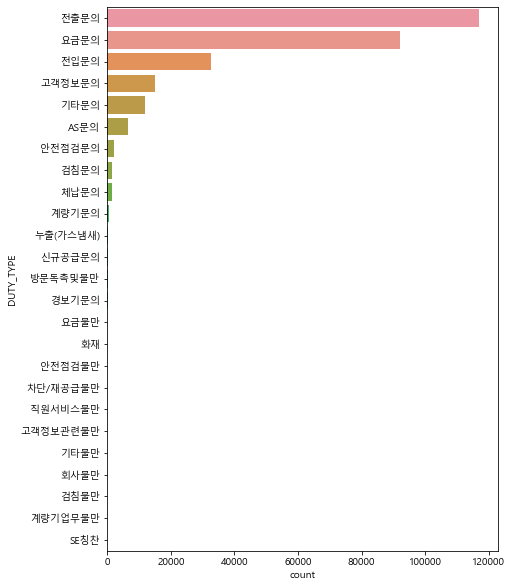

In [7]:
print(df_2022_bds['DUTY_TYPE'].value_counts())
plt.figure(figsize = (7,10))
sns.countplot(data=df_2022_bds, y='DUTY_TYPE', order = df_2022_bds['DUTY_TYPE'].value_counts().index)

- 부동산/관리실/중개인 등으로 부터의 인입콜이 '22년 기준 약 28만건 (전체 콜의 8.4%) 
- 상담 내용은 주로 이사와 관련된 전/츨입, 요금정산과 관련된 내용 
  - --> 디지털 채널을 통한 셀프 전출입 활성화를 통해, 인입콜의 상당 부분을 대체할 수 있지 않을까? 
--- 

#### 2. 카드사로 부터의 인입콜 (자동이체 해지/변경 관련)
- 콜 인입처('TEL')가 신용카드사 고객센터 전화번호인 건 추출 
- 신용카드사 홈페이지를 통해 각사 고객센터 전화번호 수집 

In [8]:
## 8개 카드사 고객센터 전화번호 
## (삼성:15888700, 롯데:15888100, 우리:15889955, KB:15881688 & 15881788, 신한:15447000, 현대:15776000, BC:15884000, 하나:18001111)
card_tel = '15888700|15888100|15889955|15881688|15881788|15447000|15776000|15884000|18001111'

In [9]:
df_2022_from_cards = df_2022[df_2022['TEL'].str.contains(card_tel, na=False)]
df_2022_from_cards.shape

(19836, 64)

In [10]:
## Top3 카드사 인입콜수 
KB = df_2022[df_2022['TEL'].str.contains('15881688', na=False)]
Shinhan = df_2022[df_2022['TEL'].str.contains('15447000', na=False)]
Woorie = df_2022[df_2022['TEL'].str.contains('15889955', na=False)]

print('- KB카드 콜수 =', KB['TEL'].value_counts())
print('- 신한카드 콜수 =', Shinhan['TEL'].value_counts())
print('- 우리카드 콜수 =', Woorie['TEL'].value_counts())

- KB카드 콜수 = 15881688    10128
Name: TEL, dtype: int64
- 신한카드 콜수 = 0215447000    8605
15447000        58
Name: TEL, dtype: int64
- 우리카드 콜수 = 15889955    1001
Name: TEL, dtype: int64


요금문의      14564
고객정보문의     2330
기타문의       1918
전입문의        302
전출문의         89
AS문의         27
검침문의         14
신규공급문의        7
안전점검문의        5
화재            3
경보기문의         1
Name: DUTY_TYPE, dtype: int64


[Text(0.5, 1.0, 'Woorie')]

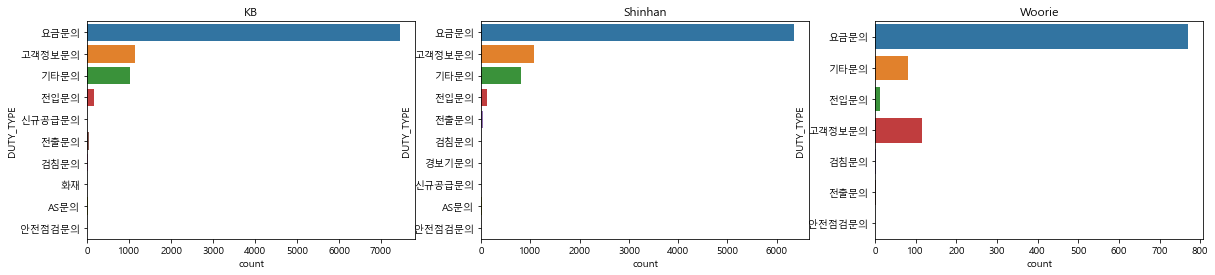

In [11]:
## Top 3 카드사별 상담유형 
card_top_3 = df_2022[df_2022['TEL'].str.contains('15881688|15447000|15889955', na=False)]
print(card_top_3['DUTY_TYPE'].value_counts())

figure, (ax1,ax2,ax3) = plt.subplots(ncols=3)
figure.set_size_inches(20,4)
sns.countplot(data=KB, y='DUTY_TYPE', ax=ax1)
sns.countplot(data=Shinhan, y='DUTY_TYPE', ax=ax2)
sns.countplot(data=Woorie, y='DUTY_TYPE', ax=ax3)
ax1.set(title = 'KB')
ax2.set(title = 'Shinhan')
ax3.set(title = 'Woorie')

In [12]:
## 실제 상담메모 확인 - KB
KB['COUNSEL_MEMO'][:20]

465                                              롯데카드해지
819                                            카드자동이체해지
909                                           자동이체해지만요청
1245                                   카드자동이체변경으로  해지요청
2005                                          자동이체 해지요청
2101                                             카드해지요청
2178                                    카드해지-카드사로 등록한다함
2185                                          세대무관 간단문의
2193             카드자동이체 해지및 LMS고지서요청  /3월요금 별도 납부하셔야함안내
2203                                               None
2232                                       카드 자동이체 해지만.
2441                                               자동해지
3192                                      카드해제만..문자발송안내
3489                               자이 해지 및 지로 고지서 변경 요청
4284    국민카드사 연락옴 >> 기존 카드해지 문의 >  본인 연락주셔서 해지요청만 가능안내.
4405                                             카드해지요청
4432                                             카드해지요청
4938                         카드사 고객번호 확인문의 -고객이 

In [13]:
## 실제 상담메모 확인 - 신한
Shinhan['COUNSEL_MEMO'][:20]

2                            자동이체만 해지
4                             자동이체 해지
168        카드자동이체 해제 문의 본인께서 연락주시라 안내
592                          고지금액확인함.
1031            이정숙01052313352 자동이체해지
2569                             None
3264                         납부자번호 확인
3277                             카드해지
3307     신한카드사전화,카드자동이체등록취소요청,고객취소요청함
4009             3-2일 신청한 국민카드 해지만 원함
4788             자동이체해지만/3월요금별도납부로안내함
5121                          자동이체 해지
5241                   자동이체 문자고지 해지요청
5534                             None
5871           자동이체 해지 요청 (카드사통한 요청 )
6712       김영남 - 자동이체접수/삼성카드로 접수되어 있슴
6858                      신한카드 3월적용안내
8351                             None
8695                        고객요청 /이소영
10021                              해지
Name: COUNSEL_MEMO, dtype: object

-일반콜의 평균 통화시간(초) = 129.25
-카드사콜의 평균 통화시간(초) = 88.63


[Text(0.5, 1.0, '카드사콜의 통화시간 분포(초)')]

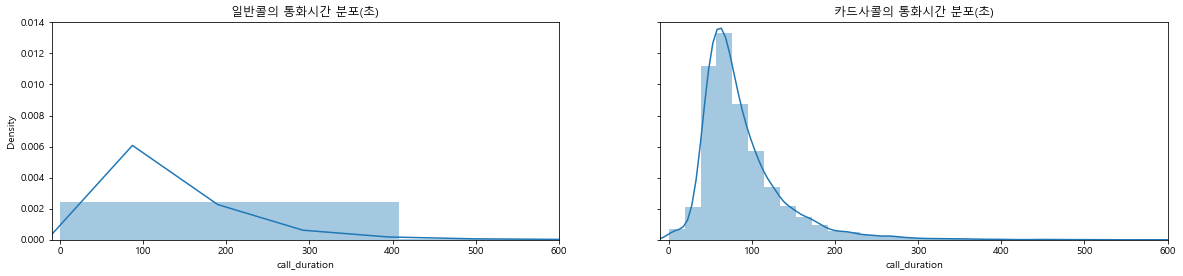

In [14]:
## 일반 콜과 카드사 콜의 질적 차이 (상담소요시간 비교)
a = np.mean(df_2022['call_duration'])
b = np.mean(df_2022_from_cards['call_duration'])

print('-일반콜의 평균 통화시간(초) =', round(a,2)) 
print('-카드사콜의 평균 통화시간(초) =', round(b,2))

figure, (ax1,ax2) = plt.subplots(ncols=2, sharex=True, sharey=True)
figure.set_size_inches(20,4)
sns.distplot(df_2022['call_duration'], ax=ax1)
sns.distplot(df_2022_from_cards['call_duration'], ax=ax2)
plt.xlim(-10, 600)
plt.ylim(0,0.014)
ax1.set(title = '일반콜의 통화시간 분포(초)')
ax2.set(title = '카드사콜의 통화시간 분포(초)')

- 메이저 8개 카드사 고객센터로부터의 인입콜은 '22년 기준 19,836건 (전체 약 3백만콜 중 0.6% 수준) 
- 카드사별로는 사별 점유율과 유사하게 KB > 신한 > 우리카드 순이며, 상담내역은 동일하게 카드 자동이체 등록/해지 관련 내용임
- 업무유형 분류체계에 자동이체 해지 관련 항목이 없음('요금문의'로 키인 하고 있음) --> 수정 필요성 검토 
- 통화시간 측면에서 카드사 콜은 일반콜대비 평균 40초 정도 짧고, 통화시간 분포도 평균 중심으로 몰려있음 --> 카드사콜은 상대적으로 대응이 짧고 간단한 내용인 것으로 추정됨 
--- 

#### 3. 수납센터로부터의 인입콜 (미납안내, 요금납부 등 관련)
- 콜 인입처('TEL')가 수납센터 전화번호인 건 추출 
- CS팀으로 부터 수납센터 전화번호 리스트 수령 

In [15]:
## 3개 수납센터 전화번호 : 미래 - '16619979|031801997xx' / F&U - '15992501|026329xxxx' / SM - '023668xxxx'
collect_tel = '16619979|031801997|15992501|026329|023668'

In [16]:
df_2022_from_sn = df_2022[df_2022['TEL'].str.contains(collect_tel, na=False)]
df_2022_from_sn.shape

(29447, 64)

In [17]:
## 3개 수납센터별 인입콜수 
Mirae = df_2022[df_2022['TEL'].str.contains('16619979|031801997', na=False)]
FnU = df_2022[df_2022['TEL'].str.contains('15992501|026329', na=False)]
SM = df_2022[df_2022['TEL'].str.contains('023668', na=False)]

a = Mirae['TEL'].value_counts()
a1 = pd.DataFrame(a)
b = FnU['TEL'].value_counts()
b1 = pd.DataFrame(b)
c = SM['TEL'].value_counts()
c1 = pd.DataFrame(c)

print('- Mirae 콜수 =', a1.sum())
print('- FnU 콜수 =', b1.sum())
print('- SM 콜수 =', c1.sum())

- Mirae 콜수 = TEL    19876
dtype: int64
- FnU 콜수 = TEL    7582
dtype: int64
- SM 콜수 = TEL    1989
dtype: int64


요금문의        18104
고객정보문의       3961
기타문의         2395
체납문의         2275
전출문의          432
AS문의          397
전입문의          246
검침문의          202
차단/재공급불만       54
계량기문의          51
신규공급문의         24
안전점검문의         22
경보기문의           7
화재              3
고객정보관련불만        2
방문독촉및불만         1
체납수납센터불만        1
누출(가스냄새)        1
요금불만            1
Name: DUTY_TYPE, dtype: int64


[Text(0.5, 1.0, 'SM')]

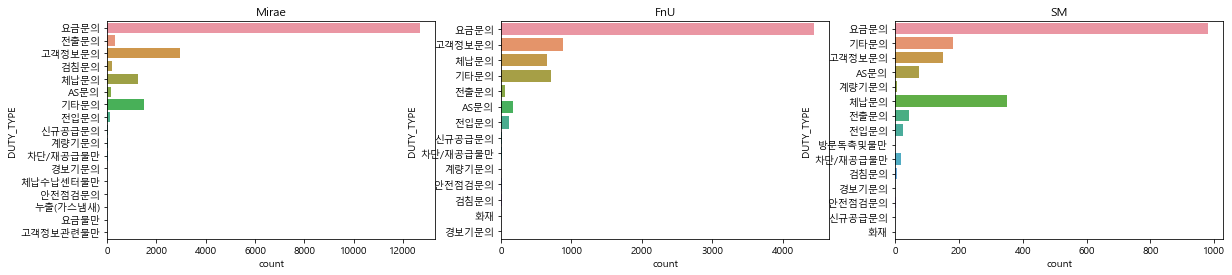

In [18]:
## 수납센터별 상담유형 
sn_3 = df_2022[df_2022['TEL'].str.contains(collect_tel, na=False)]
print(sn_3['DUTY_TYPE'].value_counts())

figure, (ax1,ax2,ax3) = plt.subplots(ncols=3)
figure.set_size_inches(20,4)
sns.countplot(data=Mirae, y='DUTY_TYPE', ax=ax1)
sns.countplot(data=FnU, y='DUTY_TYPE', ax=ax2)
sns.countplot(data=SM, y='DUTY_TYPE', ax=ax3)
ax1.set(title = 'Mirae')
ax2.set(title = 'FnU')
ax3.set(title = 'SM')

In [19]:
## 실제 상담메모 확인 
df_2022_from_sn['COUNSEL_MEMO'][:20]

1                                       수납센터: 번호변경&요금문자요청
7                   늦게방문요청. 현장정산.//전기렌지사용중 /진숙(전기사용한지3년됨)
150                     수납센터-인증x/010-8899-6663 인입 전화번호 받음
204                                      수납센터 / 2개월분 요금문자
443     수납센터 414,260원만 페이수납01021640894 요청 전산오류로 잠시후 문자...
487                            수납센타/중지철회시 납부확약서 필요/고객문자발송
659                                          신한 요금문자 수납센타
755     수납센터  폰삭제   &  사무실번호 등록요청   2021.11~2022.2월내역 ...
1084                                          문자고지등록/미납문자
1097                                    수납센터/ 번호변경 후 금액문자
1231                                            수납센터 문자발송
1424          수납센터 =>\n연락처(다른사람 사용번호로 삭제요청) 010 8912 3239
1516                                                 None
1531               수납센터 월별금액과 계좌 010-3403-8884 주인번호로 문자요청
1535                                                 카드등록
1592                     수납센터  폰 변경요청및   12~2월요금 가상번호  요청
1805                                            수납센터-요금문자
1927          

-일반콜의 평균 통화시간(초) = 129.25
-수납센터콜의 평균 통화시간(초) = 69.72


[Text(0.5, 1.0, '수납센터콜의 통화시간 분포(초)')]

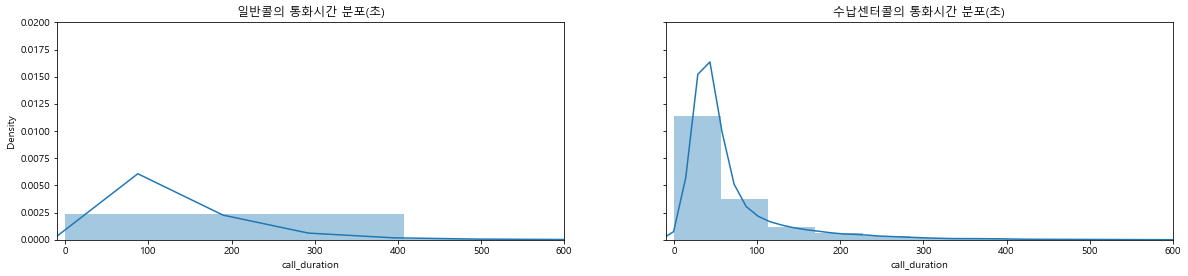

In [20]:
## 일반 콜과 수납센터 콜의 질적 차이 (상담소요시간 비교)
a = np.mean(df_2022['call_duration'])
b = np.mean(df_2022_from_sn['call_duration'])

print('-일반콜의 평균 통화시간(초) =', round(a,2)) 
print('-수납센터콜의 평균 통화시간(초) =', round(b,2))

figure, (ax1,ax2) = plt.subplots(ncols=2, sharex=True, sharey=True)
figure.set_size_inches(20,4)
sns.distplot(df_2022['call_duration'], ax=ax1)
sns.distplot(df_2022_from_sn['call_duration'], ax=ax2)
plt.xlim(-10, 600)
plt.ylim(0,0.02)
ax1.set(title = '일반콜의 통화시간 분포(초)')
ax2.set(title = '수납센터콜의 통화시간 분포(초)')

--- 
- 3개 수납센터로부터의 인입콜은 '22년 기준 29,447건 (전체 약 3백만콜 중 약 1% 수준), 특히 "미래"로부터의 콜 인입이 약 67%를 차지함 
- 업무유형은 앞서 카드사와 마찬가지로 대부분 '요금문의'로 분류되고 있으나, 상담메모 확인 결과 정보변경/납부방법 안내/재공급 요청 등 다양한 내용들임 
- 통화시간 또한 일반콜 대비 평균 60초 정도 짧은, 즉 상대적으로 대응이 짧고 간단한 통화로 해결되고 있는 것으로 판단됨 
#############################################################################################################################
- <span style="color:#ffd33d"> '부동산등 + 카드사 + 수납센터' 인입콜 합산 연간 약 33만콜(비중 약 9.9%) --> 상담원 200명 x 9.9% = 19~20명 감축 가능? </span>
--- 